# Overall Workflow
## 1. The Dataset
## 2. Missing Value Exploration
## 3. Initial Data Cleaning - Remove irrelevant features
## 4. Outlier Exploration
## 5. Feature Selection - Visualization & Hypothesis testing
## 6. Preprocessing Before Modeling
## 7. Hyperparameter Tuning - SGD classifier
## 8. Result Evaluations
## 9. Summary

# Packages

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Data formats
import csv
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

# Statistical testings
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning algorithm
from sklearn.linear_model import SGDClassifier

# Hyperparameter tuning
from hyperopt import hp
from hyperopt import Trials
from hyperopt import tpe
from timeit import default_timer as timer
from hyperopt import STATUS_OK
from hyperopt import fmin

# Model validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# 1. The Dataset

In [2]:
# Read in the dataset.
data = pd.read_csv('banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
# 41188 data points with 21 predictors.
print(data.shape)

(41188, 21)


# 2. Missing Value Exploration

In [4]:
# Inspect whether certain columns contained missing values.
for col in data.columns:
    if data[col].isnull().sum() != 0:
        print(col)
    else:
        print('No missing data!')

No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!
No missing data!


# 3. Initial Data Cleaning - Remove irrelevant features

In [5]:
# Irrelevant features could be 'customer id'.
# If a column contained the number of records corresponding to the same length of the rows 
# or only contained one record, this column (predictor) might be an irrelevant feature.
for col in data.columns:
    if len(data[col].unique()) == data.shape[0]:
        print(col)
    elif len(data[col].unique()) == 1:
        print(col)           
    else:
        continue  

# 4. Outlier Exploration
- **4.1 Box-plot visualizations**
- **4.2 Density distribution visualizations - predictors**
- **4.3 Density distribution visualizations - response**
- **4.4 Summary**

In [6]:
# Find out which column is a numerical type. 
# 11 columns are numerical types.
numeric_col = 0
for col in data.columns:
    if (data[col].dtype) != 'object':
        numeric_col += 1
print('{} numerical columns.'.format(numeric_col))

11 numerical columns.


## 4.1 Box-plot visualizations

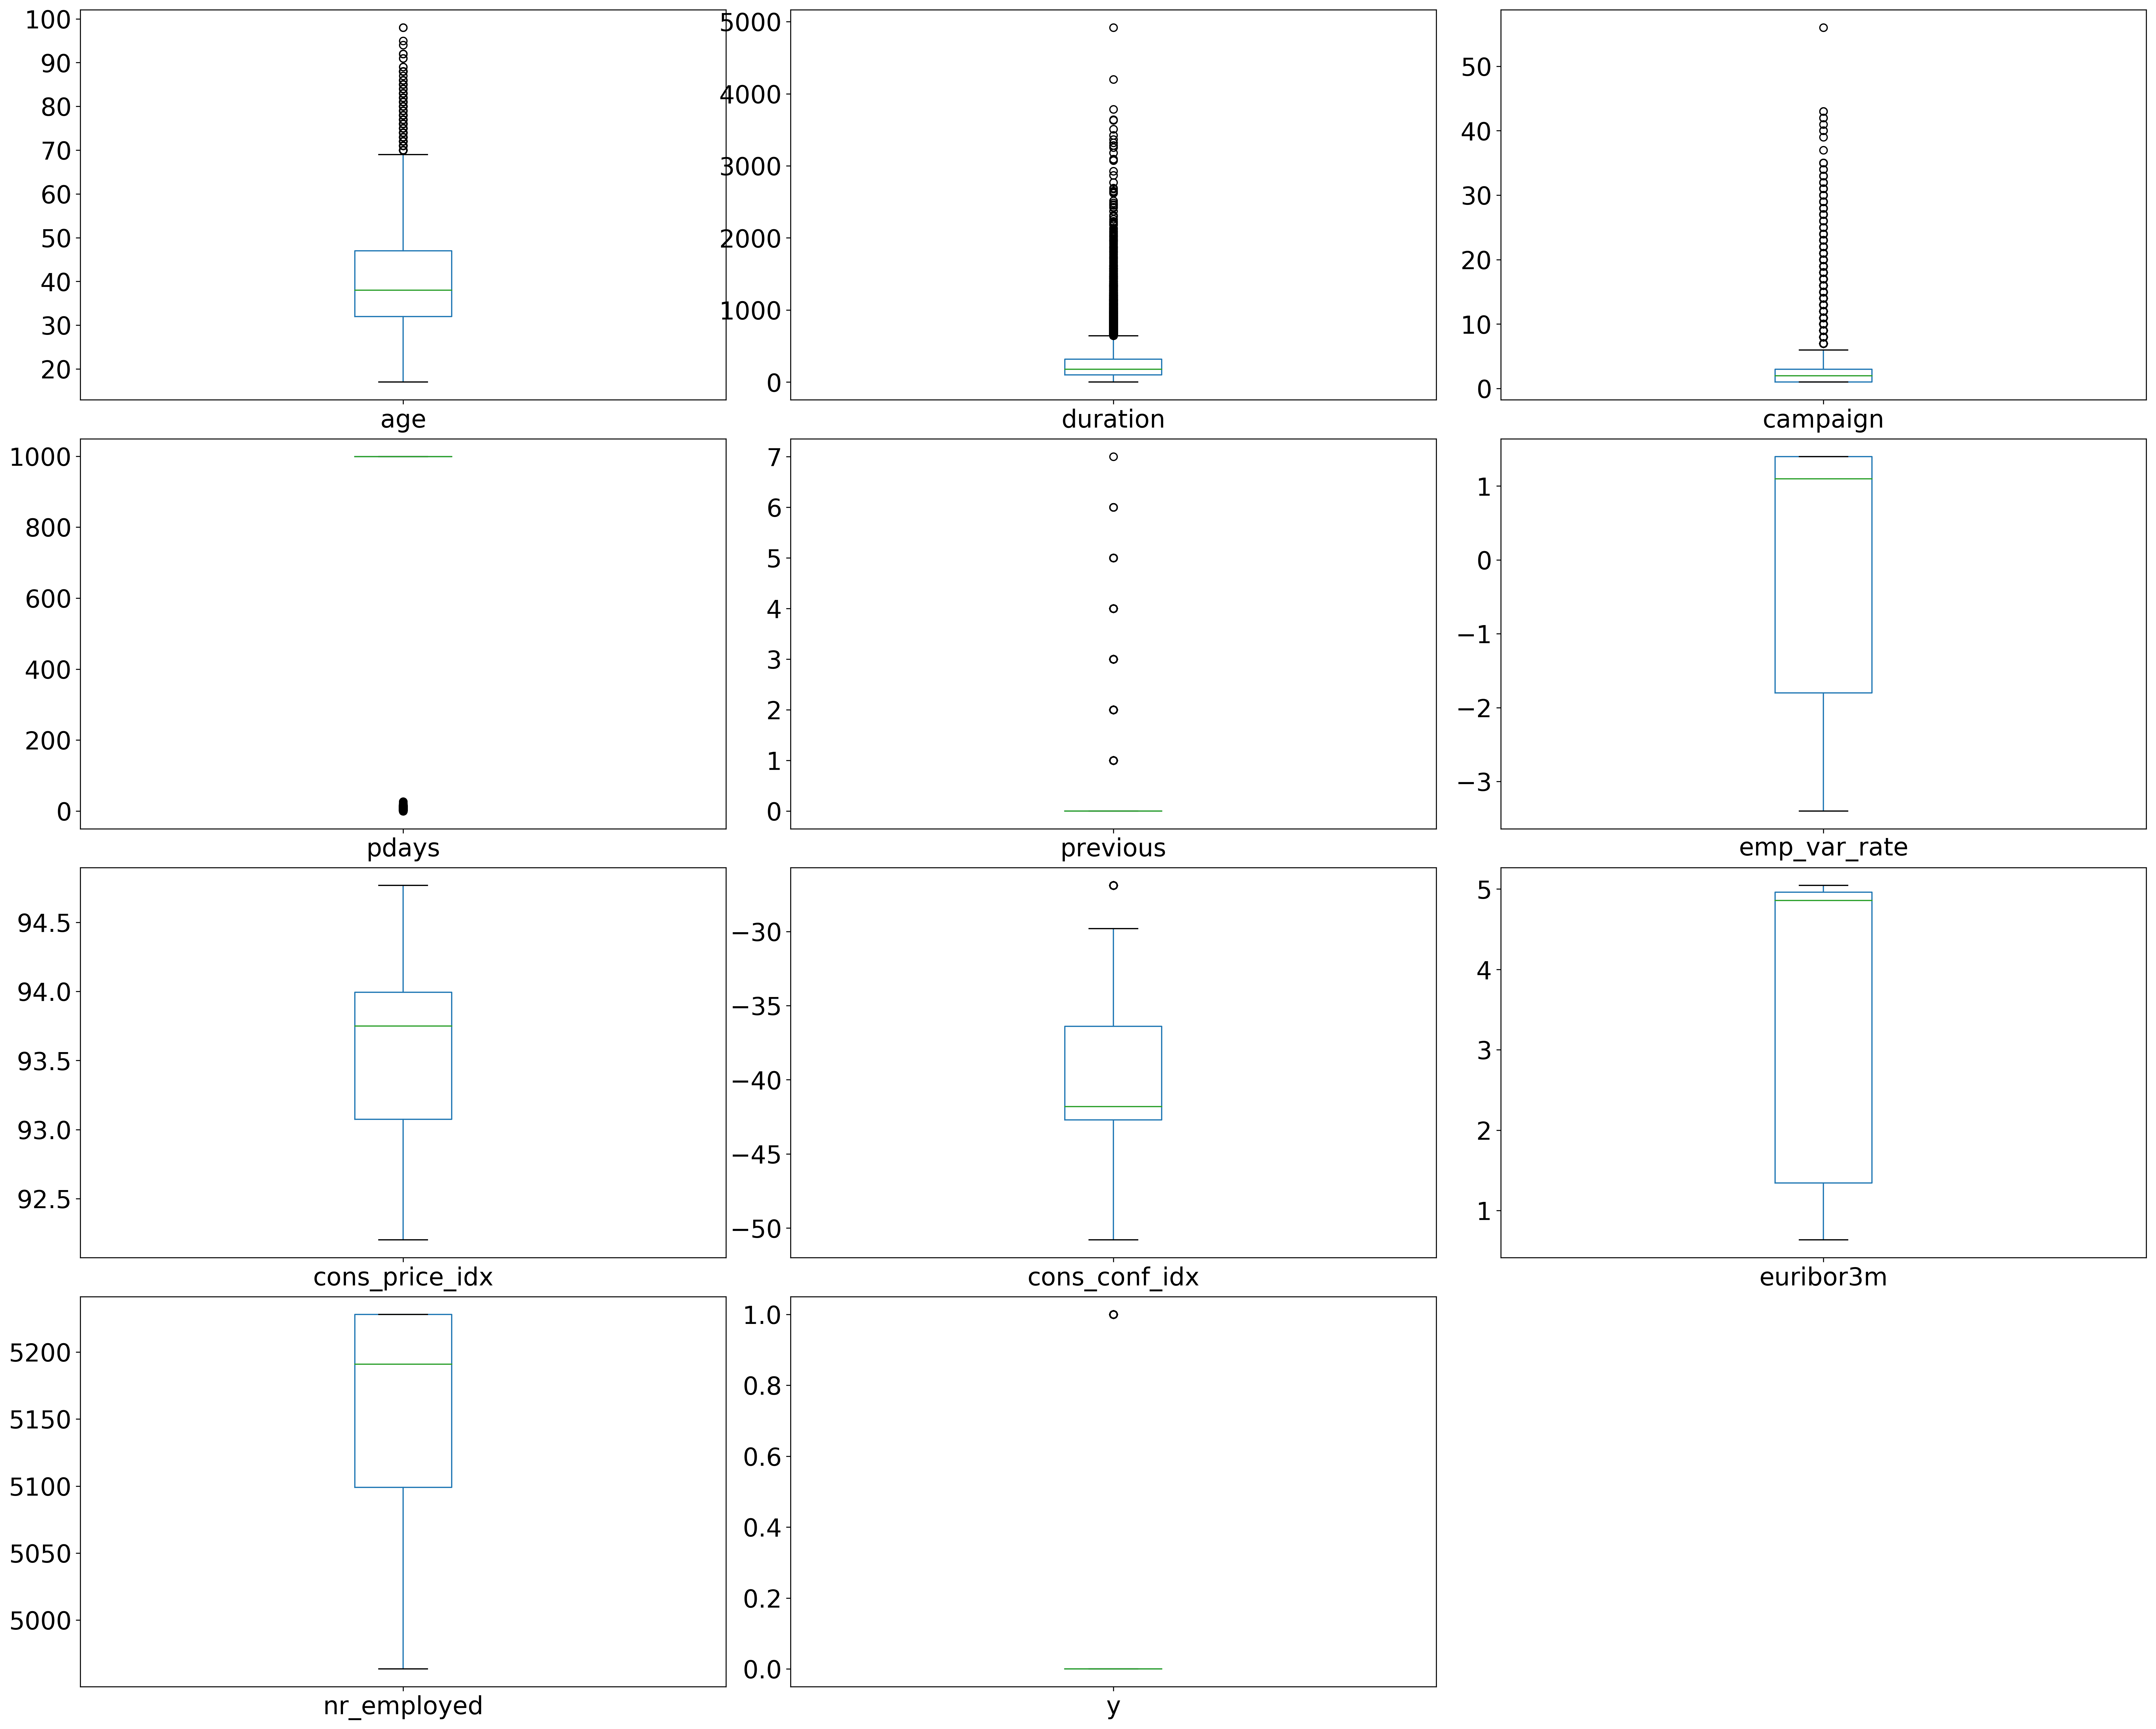

In [7]:
# Box-plot helps me to inspect the overall data distribution in numerical predictors.
# At the same time, outliers can be easily spotted.
fig = plt.figure(figsize=(30,25), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

count = 0

for col in data.columns:
    if (data[col].dtype) != 'object':
        count += 1
        ax = fig.add_subplot(4,3, count)
        data[col].plot(kind='box', use_index=True, fontsize = 20)

## 4.2 Density distribution visualizations - predictors

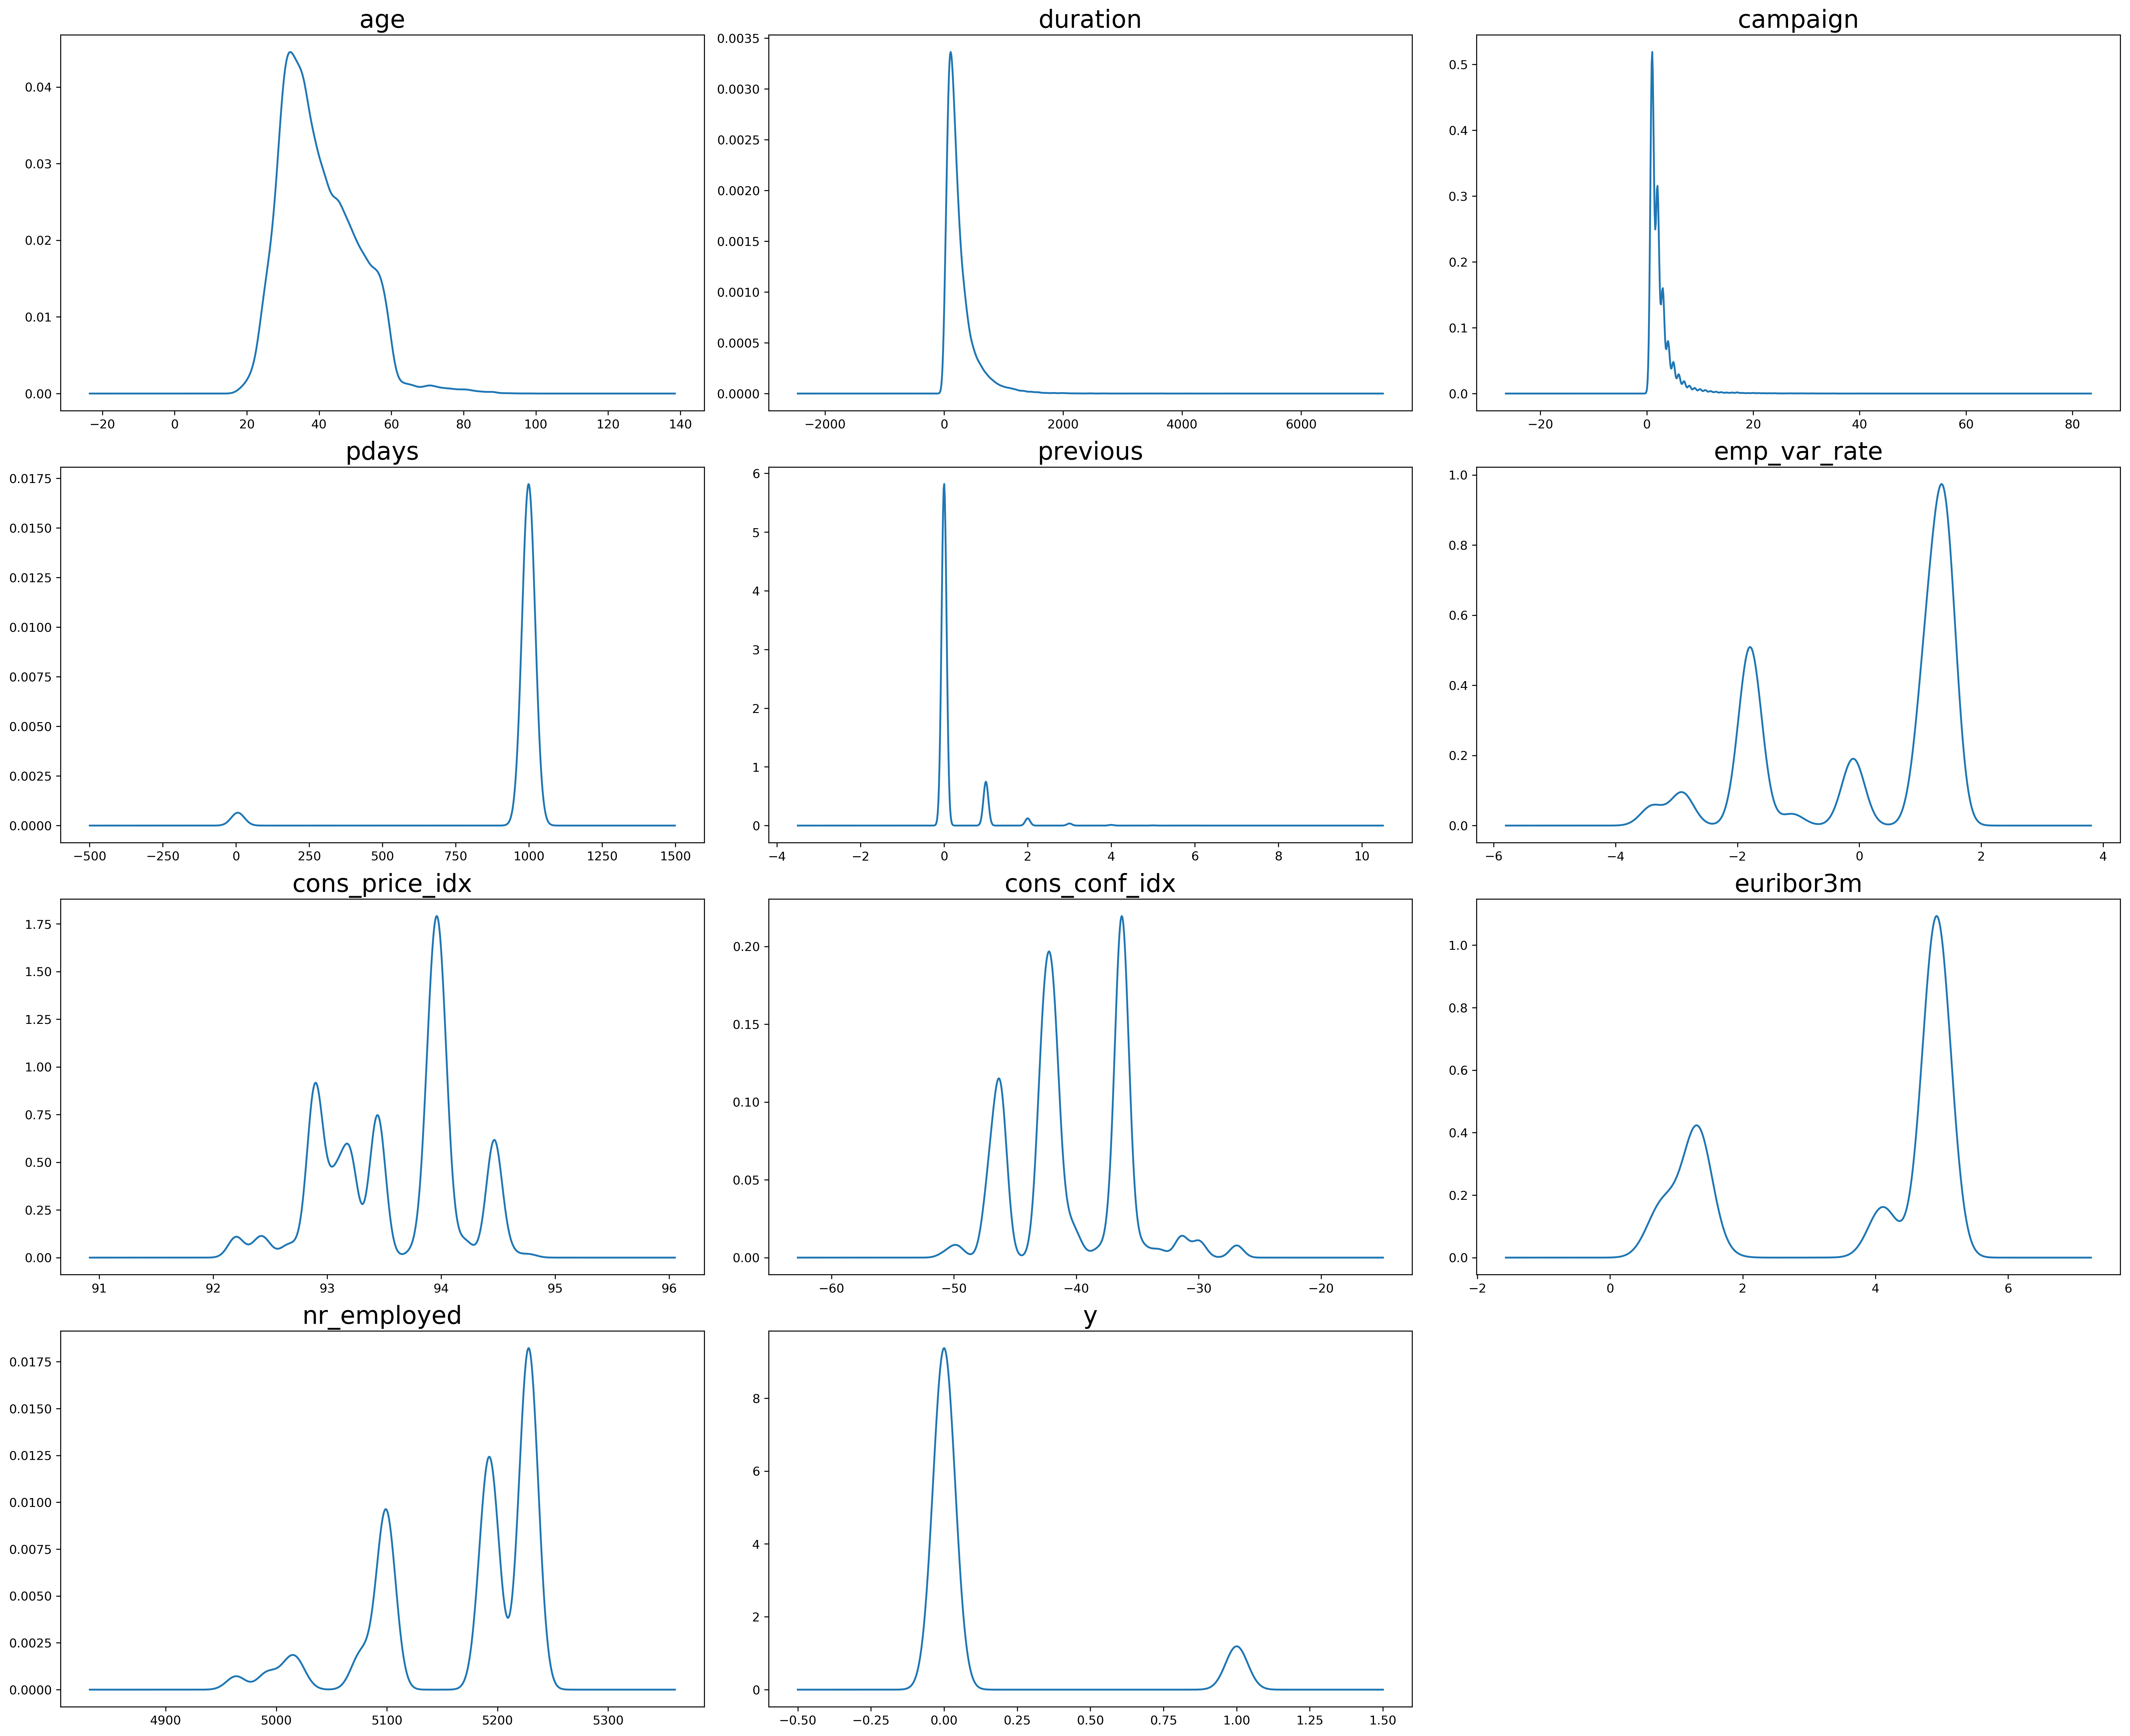

In [8]:
# Density plots help me not only inspect the data distribution in numerical predictors 
# but also tell the shape of the distribution such as a right or left skew distribution.
fig = plt.figure(figsize=(30,25),dpi=300)
fig.subplots_adjust(hspace=0.15, wspace=0.1)

count = 0

for col in data.columns:
    if (data[col].dtype) != 'object':
        count += 1
        ax = fig.add_subplot(4,3, count)
        data[col].plot(kind='density', use_index=True)
        plt.ylabel('')
        plt.title(col, fontsize=20)

## 4.3 Density distribution visualizations - response

Text(0.5, 1.0, 'y (subscription)')

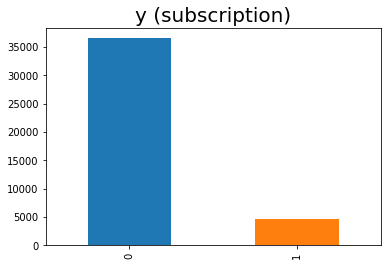

In [9]:
# Bar plot
data['y'].value_counts().plot(kind='bar')
plt.title('y (subscription)', fontsize=20)

In [10]:
# Very unbalanced labels! It might affect the model prediction!
round(data['y'].value_counts() / len(data), 4)

0    0.8873
1    0.1127
Name: y, dtype: float64

## 4.4 Summary
- Look at the attribute information might explain why such skew distributions occurred:
    - age
    - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    - previous: number of contacts performed before this campaign and for this client (numeric)

### Feature: age

In [11]:
# age: Seems like this column has no extraordinary records (such as 999 or -100).
data.age.unique()

array([44, 53, 28, 39, 55, 30, 37, 36, 27, 34, 41, 33, 26, 52, 35, 40, 32,
       49, 38, 47, 46, 29, 54, 42, 72, 48, 43, 56, 31, 24, 68, 59, 50, 45,
       25, 57, 63, 58, 60, 64, 51, 23, 20, 74, 80, 61, 62, 75, 21, 82, 77,
       70, 76, 73, 66, 22, 71, 19, 79, 88, 65, 67, 81, 18, 84, 69, 98, 85,
       83, 78, 92, 86, 94, 17, 91, 89, 87, 95])

### Feature: duration

In [12]:
print("Average contact duration (in seconds) when a client didn't subscribed to a term deposit: {}.".format(
    round(data[data['y'] == 0]['duration'].mean(),4)))

print("Average contact duration (in seconds) when a client subscribed to a term deposit: {}.".format(
    round(data[data['y'] == 1]['duration'].mean(),4)))

Average contact duration (in seconds) when a client didn't subscribed to a term deposit: 220.8448.
Average contact duration (in seconds) when a client subscribed to a term deposit: 553.1912.


In [13]:
# Verify the attribute information described by the dataset author.
# It's indeed that when the duration is 0 (second), 
# then clients didn't subscribe to term deposits!
print(data[data['duration'] == 0]['y'])

8976     0
30156    0
32502    0
36969    0
Name: y, dtype: int64


In [14]:
# Since the purpose is to build a realistic 'prediction' model, 
# I dropped this column from the overall feature space.
data.drop(columns='duration', inplace=True)
print(data.shape)

(41188, 20)


### Feature: campaign

In [15]:
sorted(data.campaign.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 39,
 40,
 41,
 42,
 43,
 56]

### Feature: pdays

In [16]:
# pdays: 999 means a client was not previously contacted.
sorted(data.pdays.unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 25,
 26,
 27,
 999]

### Feature: previous

In [16]:
# previous: it's a count-type (discrete values) column.
sorted(data.previous.unique())

[0, 1, 2, 3, 4, 5, 6, 7]

In [17]:
# Question: If the bank didn't contact clients previously, did it affect the subscription?
# Answer: Still, 3141 customers have subscribed, but the proportion is smaller (around 8%).
print(data[data['previous'] == 0]['y'].value_counts())

0    32422
1     3141
Name: y, dtype: int64


# 5. Feature Selection - Visualization & Hypothesis testing
- **5.1 Distribution plots - numerical features**
- **5.2 Relationship between numerical predictors: Correlation Plot**
- **5.3 Distribution plots - categorical features**
- **5.4 Hypothesis testing - two sample t-test for numerical features**
- **5.5 Hypothesis testing - chi-square test for categorical features**
- **5.6 Overall feature selection summary**

## 5.1 Distribution plots - numerical features

In [20]:
# Helper function for inspecting the relationship between numerical features 
# and the response variable.
def num_feature_distribution_plot(col_name, response_name, data):
    # Set the plot size
    plt.figure(figsize = (10, 8))

    # KDE plot of y = 0 
    sb.kdeplot(data.loc[data[response_name] == 0, col_name], label = 'response = 0')
    
    # KDE plot of y = 1 
    sb.kdeplot(data.loc[data[response_name] == 1, col_name], label = 'response = 1')

    # Labeling
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name, fontsize=20)

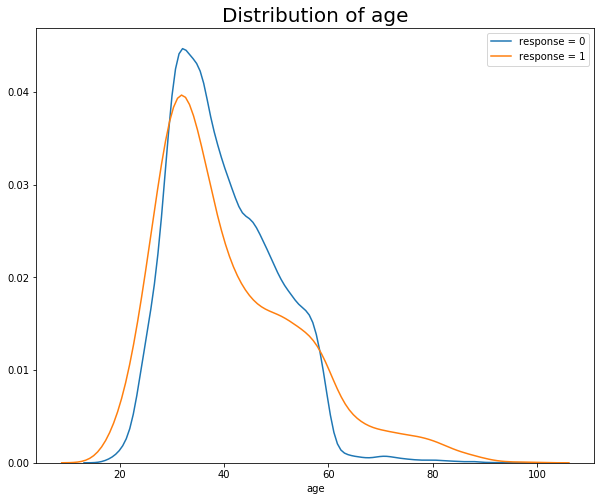

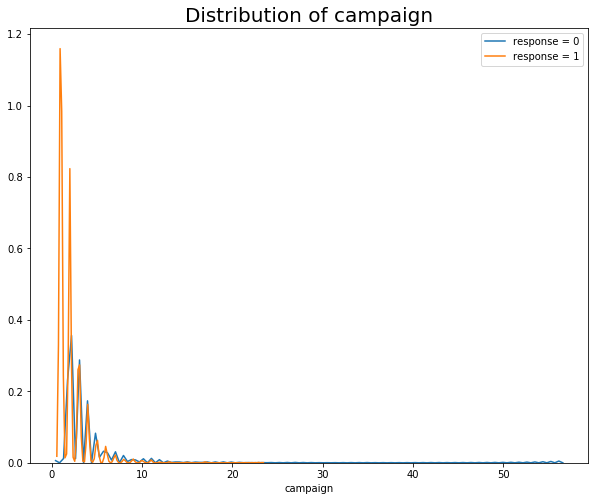

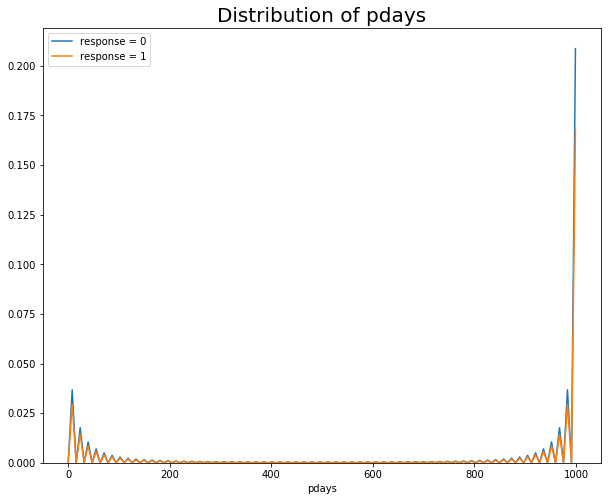

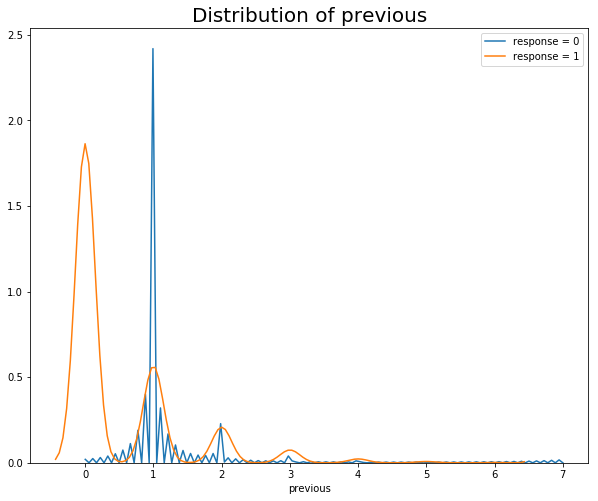

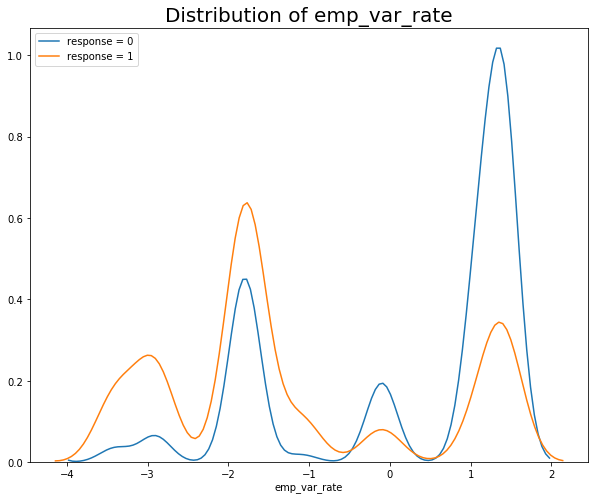

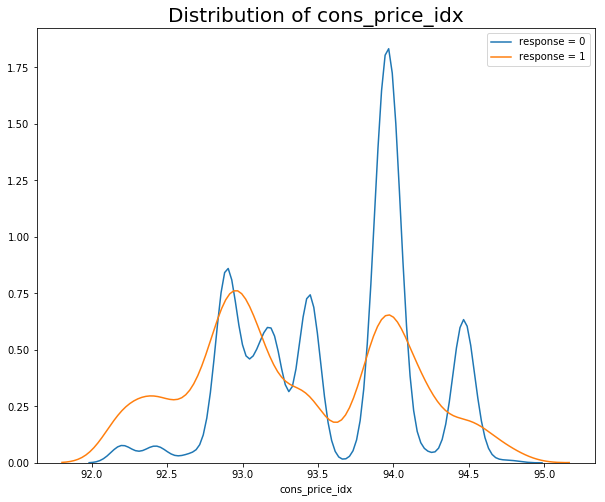

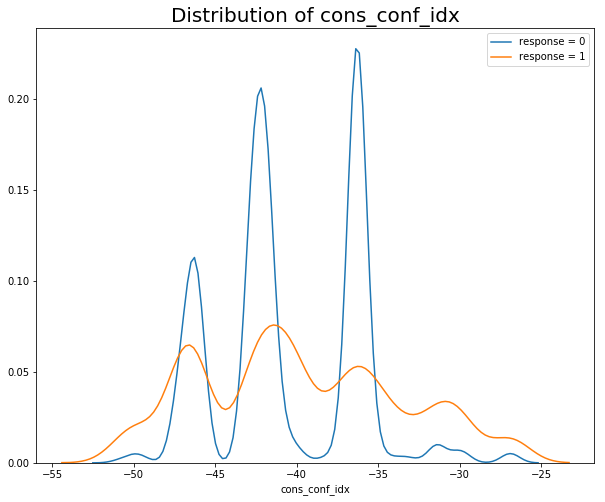

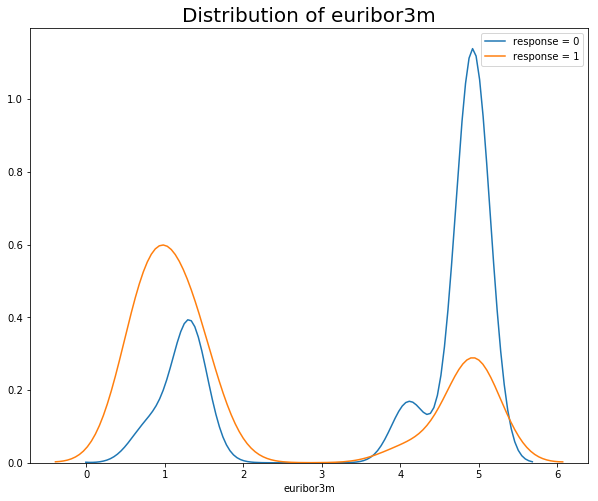

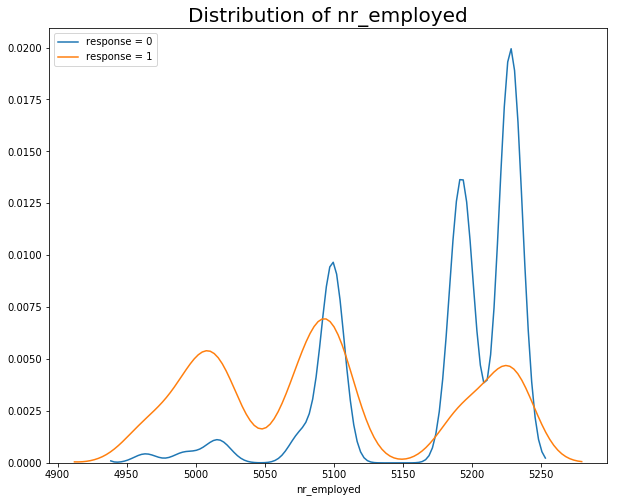

In [21]:
for col in data.columns:
    if (data[col].dtype) != 'object' and col != 'y':
        num_feature_distribution_plot(col_name=col, response_name='y', data=data)

## 5.2 Relationship between numerical predictors: Correlation Plot

In [22]:
num_col_names = []
for col in data.columns:
    if (data[col].dtype) != 'object' and col != 'y':
        num_col_names.append(col)
        
correlation_matrix = data[num_col_names].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

In [23]:
correlation_matrix

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


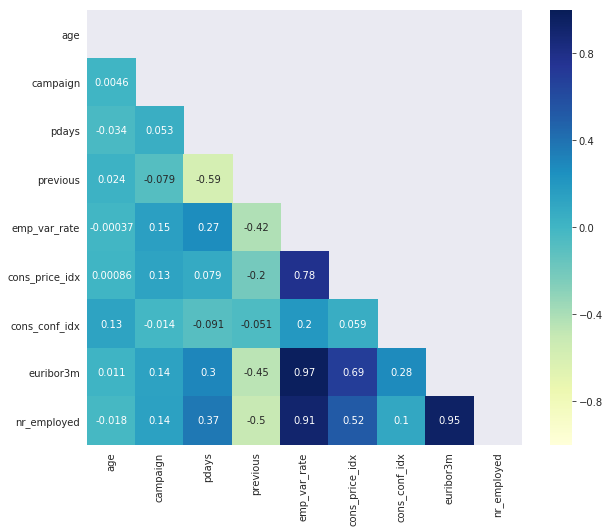

In [24]:
# Correlation plot helps me to inspect the relationship among numerical features.
# There might be a multicollinearity issue existed!
# For instance, euribor3m and emp_var_rate have a very high positive correlation!
with sb.axes_style("darkgrid"):
    fig = plt.figure(figsize=(10,8))
    ax = sb.heatmap(correlation_matrix, mask = mask, 
                    vmin = -1, vmax = 1, square = True,
                    annot = True, cmap = "YlGnBu")

## 5.3 Distribution plots - categorical features

In [25]:
for each in data.columns:
    if data[each].dtype == 'object':
        print(each)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


In [26]:
# Helper function for inspecting the relationship between categorical features 
# and the response variable.
def cate_feature_distribution_plot(col_name, response_name, data):
    plt.figure(figsize = (10, 8))
    pd.crosstab(data[col_name], data[response_name]).plot(kind='bar')
    plt.title('Distribution of '+ col_name, fontsize=20)
    plt.xlabel('')
    plt.show()

<Figure size 720x576 with 0 Axes>

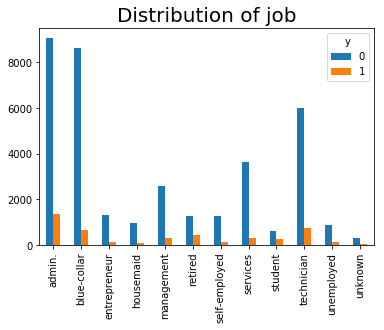

<Figure size 720x576 with 0 Axes>

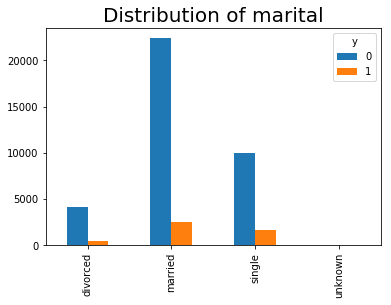

<Figure size 720x576 with 0 Axes>

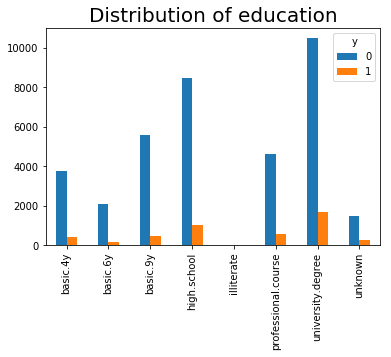

<Figure size 720x576 with 0 Axes>

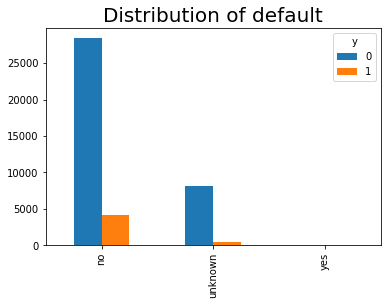

<Figure size 720x576 with 0 Axes>

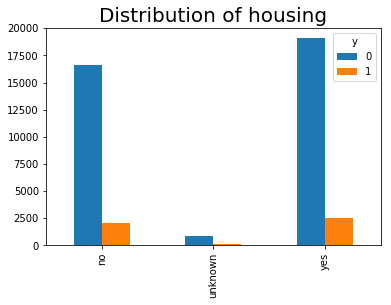

<Figure size 720x576 with 0 Axes>

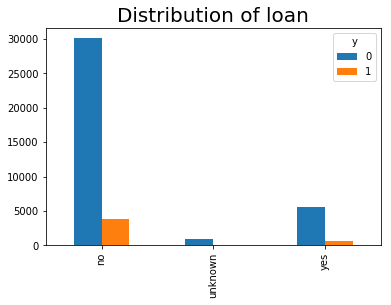

<Figure size 720x576 with 0 Axes>

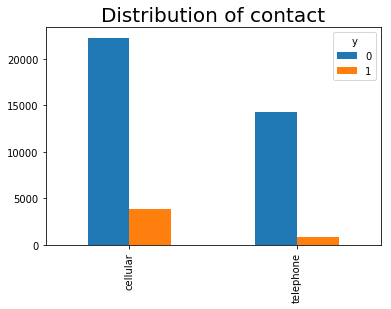

<Figure size 720x576 with 0 Axes>

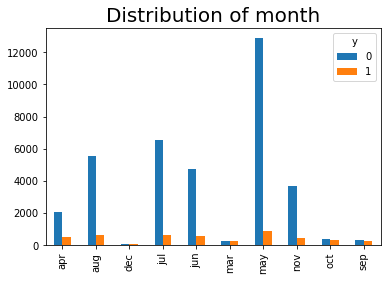

<Figure size 720x576 with 0 Axes>

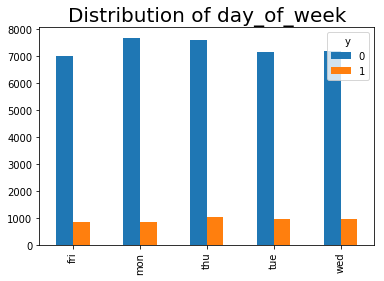

<Figure size 720x576 with 0 Axes>

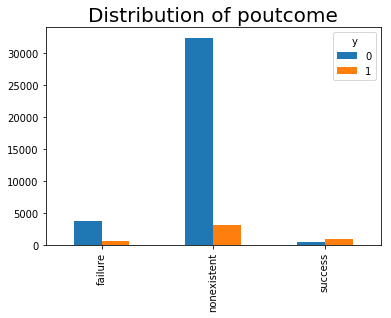

In [27]:
for col in data.columns:
    if data[col].dtype == 'object':
        cate_feature_distribution_plot(col_name=col, response_name='y', data=data)

## 5.4 Hypothesis testing - two sample t-test for numerical features

- **Before performing the two sample t-test, I need to determine whether two samples have the same variance by conducting the F-test.**

- **F-test, null (h0) and alternative (h1) hypotheses:**

$$H_0: \sigma_1^2 = \sigma_2^2$$

$$H_1: \sigma_1^2 \neq \sigma_2^2$$

- **F-test, 95% confidence interval for the estimator (if the C.I. contains 1, two variances are equal):**

$$C.I. = (\frac {1}{F_\frac{\alpha}{2}} \frac {s_1^2}{s_2^2}, \frac {1}{F_{1-\frac{\alpha}{2}}} \frac {s_1^2}{s_2^2})$$

In [28]:
# Helper function for performing an f-test to compare two sample variances.
def f_test_two_p_variance(var1, var2, n1, n2, alpha_level):
    '''
    Perform the F-test for comparing variances between two samples.
    Outputs: F ratio, p-value, and the confidence interval given an alpha level.
    
    var1: the variance of the population 1
    var2: the variance of the population 2
    n1: sample size of the population 1
    n2: sample size of the population 2
    alpha_level: can be either 0.1, 0.05, or 0.1
    '''
    # F test statistic
    F_ratio = var1 / var2
    
    # p-value (two-sided test: the interest is to compare whether two variances are equal)
    p_value = min(f.cdf(F_ratio, n1-1, n2-1), 1 - f.cdf(F_ratio, n1-1, n2-1))
    p_value = p_value*2

    # 95% C.I.
    upper = 1 / (f.ppf(alpha_level/2, n1-1, n2-1)) * F_ratio
    lower = 1 / (f.ppf(1 - (alpha_level/2), n1-1, n2-1)) * F_ratio
    
    return F_ratio, p_value, (lower, upper)

In [29]:
# Loop into numerical columns.
for num_col in data.columns:
    if data[num_col].dtype != 'object' and num_col != 'y':
        f_results = f_test_two_p_variance(var1=data[data.y == 0][num_col].var(), 
                                          var2=data[data.y == 1][num_col].var(), 
                                          n1=data[data.y == 0][num_col].count(), 
                                          n2=data[data.y == 1][num_col].count(), 
                                          alpha_level=0.05)
        print('Column name: {}.'.format(num_col))
        print('F ratio: {}.'.format(f_results[0]))
        print('p-value: {}.'.format(f_results[1]))
        print('95 C.I. {}.'.format(f_results[2]))
        if f_results[1] <= 0.05:
            print('Decision: reject H0, two variances are unequal.')
        else: 
            print('Decision: do not reject H0, two variances are equal.')
        print('----------------------------------------------------')

Column name: age.
F ratio: 0.5116732208618104.
p-value: 1.4519956981490723e-240.
95 C.I. (0.48985713579190454, 0.5340692820344317).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: campaign.
F ratio: 2.9738987133192976.
p-value: 2.220446049250313e-16.
95 C.I. (2.8471013264836484, 3.104066982419835).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: pdays.
F ratio: 0.08945751799595306.
p-value: 0.0.
95 C.I. (0.08564333983854382, 0.09337309528962841).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: previous.
F ratio: 0.2262169469875277.
p-value: 0.0.
95 C.I. (0.21657179074616334, 0.23611851770972228).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: emp_var_rate.
F ratio: 0.8342004075803837.
p-value: 3.622300489970913e-17.
95 C.I. (

- **Two sample t-test, null (h0) and alternative (h1) hypotheses:**

$$H_0: \mu_1 = \mu_2$$

$$H_1: \mu_1 \neq \mu_2$$

In [30]:
# Perform two sample t-test to see whether they have 'different' means.
# If they are different to each other in the aspect of mean given a predictor, 
# then it might indicate this predictor has some prediction power 
# on the response variable (subscription).

# Collecting results.
t_test_results = np.array([])
t_test_p_values = np.array([])
num_col_names = np.array([])

# Loop into numerical columns.
for num_col in data.columns:
    if data[num_col].dtype != 'object' and num_col != 'y':
        t_test_results = np.append(t_test_results, 
                                   (ttest_ind(a=data[data.y == 0][num_col], 
                                              b=data[data.y == 1][num_col], 
                                              equal_var=False))[0])
        t_test_p_value = ttest_ind(a=data[data.y == 0][num_col], 
                                   b=data[data.y == 1][num_col], 
                                   equal_var=False)[1]
        t_test_p_values = np.append(t_test_p_values, t_test_p_value)
        num_col_names = np.append(num_col_names, num_col)
        # Decision (reject or not reject H0)
        if t_test_p_value <= 0.05:
            print('Column name: {}.'.format(num_col))
            print('Decision: reject H0, two means are unequal.')
            print('p-value: {}.'.format(t_test_p_value))
        else:
            print('Column name: {}.'.format(num_col))
            print('Decision: do not reject H0, two means are equal.')
            print('p-value: {}.'.format(t_test_p_value))
        print('-------------------------------------------')

Column name: age.
Decision: reject H0, two means are unequal.
p-value: 1.8047932698425662e-06.
-------------------------------------------
Column name: campaign.
Decision: reject H0, two means are unequal.
p-value: 4.0995502865896684e-89.
-------------------------------------------
Column name: pdays.
Decision: reject H0, two means are unequal.
p-value: 1.66343249509085e-206.
-------------------------------------------
Column name: previous.
Decision: reject H0, two means are unequal.
p-value: 1.6759513761035004e-161.
-------------------------------------------
Column name: emp_var_rate.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: cons_price_idx.
Decision: reject H0, two means are unequal.
p-value: 6.916521411868203e-122.
-------------------------------------------
Column name: cons_conf_idx.
Decision: reject H0, two means are unequal.
p-value: 7.588202230489769e-18.
-------------------------------------------
Colum

In [31]:
# Sort the t-test statistic result and return the corresponding indexes.
abs(t_test_results).argsort()

array([0, 6, 1, 5, 3, 2, 4, 8, 7])

In [32]:
# Absolute t-test statistics.
abs(t_test_results)[[0, 6, 1, 5, 3, 2, 4, 8, 7]]

array([ 4.77954278,  8.63645776, 20.24937806, 24.08246699, 28.12553398,
       32.25086915, 59.13666291, 60.97515591, 62.57987243])

In [33]:
# Column names: From the least to the most important numerical feature.
num_col_names[[0, 6, 1, 5, 3, 2, 4, 8, 7]]

array(['age', 'cons_conf_idx', 'campaign', 'cons_price_idx', 'previous',
       'pdays', 'emp_var_rate', 'nr_employed', 'euribor3m'], dtype='<U32')

## 5.5 Hypothesis testing - chi-square test for categorical features

**H0: The categorical predictor and the response variable (subscribed or not) are independent variables.**

**H1: They are not independent to each other.**

In [34]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


In [35]:
# Collecting results.
chi_square_test_results = np.array([])
cate_col_names = np.array([])

# Loop into categorical features.
for col in data.columns:
    if data[col].dtype == 'object':
        chi_square_test_results = np.append(chi_square_test_results, 
                                            chi2_contingency(pd.crosstab(data[col], data['y']).values)[0])
        chi_square_test_p = chi2_contingency(pd.crosstab(data[col], data['y']).values)[1]
        cate_col_names = np.append(cate_col_names, col)
        
        if chi_square_test_p <= 0.05:
            print('Column name: {}.'.format(col))
            print('Decision: reject H0, {} and {} are not independent to each other.'.
                 format(col, 'y (subscribed or not)'))
            print('p-value: {}.'.format(chi_square_test_p))
        else:
            print('Column name: {}.'.format(col)) 
            print('Decision: do not reject H0, {} and {} are independent to each other.'.
                  format(col, 'y (subscribed or not)'))
            print('p-value: {}.'.format(chi_square_test_p))
        print('---------------------------------------------------------------------------------------------')

Column name: job.
Decision: reject H0, job and y (subscribed or not) are not independent to each other.
p-value: 4.189763287563623e-199.
---------------------------------------------------------------------------------------------
Column name: marital.
Decision: reject H0, marital and y (subscribed or not) are not independent to each other.
p-value: 2.068014648442211e-26.
---------------------------------------------------------------------------------------------
Column name: education.
Decision: reject H0, education and y (subscribed or not) are not independent to each other.
p-value: 3.3051890144025054e-38.
---------------------------------------------------------------------------------------------
Column name: default.
Decision: reject H0, default and y (subscribed or not) are not independent to each other.
p-value: 5.1619579513916376e-89.
---------------------------------------------------------------------------------------------
Column name: housing.
Decision: do not reject H0,

In [36]:
abs(chi_square_test_results).argsort()

array([5, 4, 8, 1, 2, 3, 6, 0, 7, 9])

In [37]:
chi_square_test_results[[5, 4, 8, 1, 2, 3, 6, 0, 7, 9]]

array([1.09402755e+00, 5.68449586e+00, 2.61449391e+01, 1.22655152e+02,
       1.93105905e+02, 4.06577515e+02, 8.62318364e+02, 9.61242440e+02,
       3.10114935e+03, 4.23052380e+03])

In [38]:
# From the least to the most important categorical feature.
cate_col_names[[5, 4, 8, 1, 2, 3, 6, 0, 7, 9]]

array(['loan', 'housing', 'day_of_week', 'marital', 'education',
       'default', 'contact', 'job', 'month', 'poutcome'], dtype='<U32')

## 5.6 Overall feature selection summary

### Numerical predictors
- **'age'** might be the least important predictor, and the **'euribor3m'** might be the most important predictor. In other words: 
- **age won't affect the probability of subscription significantly. Notice that 'age' is still statistically significant observed from the two sample t-test result (p-value is less than 0.05).**
- **euribor 3 month rate** (the rate of interest used by the main European banks when they lend money to each other in euros) affects the most on the probability of subscription. The euribor 3 month rate of population who didn't subscribed is higher than the subscribed population on average. **It makes sense that the population with higher rate needed to pay back "more interest" to banks and thus tended not to subscribe since they have 'less' money.**
    
| Column name | Rank |
| -- | -- |
| **age** | 9
| cons_conf_idx | 8
| campaign | 7
| cons_price_idx | 6
| previous | 5
| pdays | 4
| emp_var_rate | 3
| nr_employed | 2
| **euribor3m** | 1 

### Categorical predictors
- Columns **'loan'** and **'housing'** didn't pass the chi-square test for testing independence. Both p-values are larger than 0.05. However, for column **'housing'**, the corresponding p-value is 0.0583 which is very close to 0.05. Therefore, **'housing'** still could contribute some degree on the predictions.
- **'poutcome'** (outcome of the previous marketing campaign, levels: 'failure','nonexistent','success') is the most important categorical predictor among all categorical predictors. Previous decisions made by the customers did affect the probability of subscription followings. **It might indicate that customers felt satisfied with the service or they became familiar with the service previously tended to subscribe in the next time.**

| Column name | Rank |
| -- | -- |
| **loan** | p-value is larger than 0.05
| **housing** | p-value is larger than 0.05
| day_of_week | 8
| marital | 7
| education | 6
| default | 5
| contact | 4
| job | 3
| month | 2
| **poutcome** | 1 

# 6. Preprocessing Before Modeling
- **6.1 One-hot encoding**
- **6.2 Dummy feature generation**
- **6.3 Train & test splitting (80%/20%)**
- **6.4 Standardization**
    - Why standardization is needed? -> Regularization purpose.

## 6.1 One-hot encoding

In [39]:
# Collecting column names.
dummy_features = []
binary_features = []

# Loop into categorical columns.
for each in data.columns:
    if data[each].dtype == 'object':
        if len(data[each].unique()) > 2:
            dummy_features.append(each)
        else: 
            binary_features.append(each)

In [40]:
# One-hot encoding for categorical features containing two levels.
le = LabelEncoder()
le_count = 0

for col in binary_features:
    print(col)
    le.fit(data[col])
    data[col] = le.transform(data[col])
            
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

contact
1 columns were label encoded.


In [41]:
# Make sure the transformation is correct!
# 0: cellular
# 1: telephone
data['contact'].unique()

array([0, 1])

## 6.2 Dummy feature generation

In [42]:
# Create dummy features
sum_len = 0
for col in dummy_features:
    sum_len += len(data[col].unique())
    print(col, len(data[col].unique()))
    
print('{} columns will be additionally added.'.format(sum_len - len(dummy_features)))

job 12
marital 4
education 8
default 3
housing 3
loan 3
month 10
day_of_week 5
poutcome 3
42 columns will be additionally added.


In [43]:
# Original dimension of the feature space.
print(data.shape)

# 20 + 42 = 62, correct dummy feature transformation!
data = pd.get_dummies(data, columns = dummy_features)
print(data.shape)

(41188, 20)
(41188, 62)


In [44]:
data.head()

,age,contact,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,0,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,0,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,0,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,0,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,0,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1


## 6.3 Train & test splitting (80% & 20%)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(data[data.columns.difference(['y'])], 
                                                    data.y, 
                                                    test_size=0.2, random_state=0) 

In [46]:
# Make sure the splitting is correct!
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(32950, 61) (8238, 61)
(32950,) (8238,)


## 6.4 Standardization

In [47]:
# Test data are unseen data! 
# Since my purpose is to build a prediction model, 
# I shouldn't contaminate train and test data together when standardizing data.  
std_scaler = StandardScaler().fit(x_train)

train_standardized_data = std_scaler.transform(x_train)
test_standardized_data = std_scaler.transform(x_test)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [48]:
# Make sure the standardization is correct (mean must be 0 and variance must be 1).
pd.DataFrame(train_standardized_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,...,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04,3.295000e+04
mean,4.078680e-17,8.445074e-16,-1.162938e-16,8.209026e-15,2.458846e-15,-1.355597e-15,5.029327e-16,1.253423e-16,3.245581e-15,4.337653e-16,...,3.421724e-15,3.886825e-16,1.384020e-15,-1.101751e-15,-1.019587e-14,1.594267e-15,1.165377e-15,6.122939e-16,6.648720e-16,1.659239e-15
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,...,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.211847e+00,-5.665389e-01,-2.222855e+00,-2.369536e+00,-7.563842e-01,-4.872569e-01,-5.084272e-01,-5.173009e-01,-4.913539e-01,-4.955384e-01,...,-7.080566e-01,-3.358008e-01,-1.316081e-01,-1.176697e-01,-2.818376e+00,-5.156350e+00,-3.408701e-01,-2.505383e+00,-1.856662e-01,-3.513546e-01
25%,-7.718537e-01,-5.665389e-01,-4.721228e-01,-8.601860e-01,-7.563842e-01,-4.872569e-01,-5.084272e-01,-5.173009e-01,-4.913539e-01,-4.955384e-01,...,-7.080566e-01,-3.358008e-01,-1.316081e-01,-1.176697e-01,-9.408363e-01,1.951639e-01,-3.408701e-01,3.991406e-01,-1.856662e-01,-3.513546e-01
50%,-1.958565e-01,-2.044507e-01,-2.775970e-01,-2.229433e-01,-7.563842e-01,-4.872569e-01,-5.084272e-01,-5.173009e-01,-4.913539e-01,-4.955384e-01,...,-7.080566e-01,-3.358008e-01,-1.316081e-01,-1.176697e-01,3.325649e-01,1.951639e-01,-3.408701e-01,3.991406e-01,-1.856662e-01,-3.513546e-01
75%,6.681393e-01,1.576375e-01,8.895580e-01,7.268765e-01,1.322080e+00,-4.872569e-01,-5.084272e-01,-5.173009e-01,-4.913539e-01,-4.955384e-01,...,1.412316e+00,-3.358008e-01,-1.316081e-01,-1.176697e-01,8.466366e-01,1.951639e-01,-3.408701e-01,3.991406e-01,-1.856662e-01,-3.513546e-01
max,5.564115e+00,1.464116e+01,2.942886e+00,2.061805e+00,1.322080e+00,2.052306e+00,1.966850e+00,1.933111e+00,2.035193e+00,2.018007e+00,...,1.412316e+00,2.977956e+00,7.598316e+00,8.498366e+00,8.466366e-01,1.951639e-01,2.933669e+00,3.991406e-01,5.386010e+00,1.382390e+01


# 7. Hyperparameter Tuning - SGD classifier
- **7.1 Bayesian Optimization**
- **7.2 Continue Bayesian Optimization**
- **Why SGD classifier rather than Logistic Regression?** 
    - SGD classifier implements regularised linear models with Stochastic Gradient Descent and Logistic Regression by default uses Gradient Descent.
    - Stochastic gradient descent considers only 1 random point while changing weights, unlike gradient descent which considers the whole training data. Therefore, stochastic gradient descent is much faster than gradient descent when dealing with large data sets.
- Hyperparameters (reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
    - loss: 'log' loss gives logistic regression.
    - penalty: Regularization term.
    - alpha: Constant that multiplies the regularization term.
    - l1_ratio: The Elastic Net mixing parameter. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.
    - fit_intercept: Whether the intercept should be estimated or not. 
    - random_state: The seed of the pseudo random number generator to use when shuffling the data.

## 7.1 Bayesian Optimization

In [ ]:
# Define the search space (hyperparameter space).
space = {
    'loss':'log',
    'penalty': hp.choice('penalty', ['none', 'l2', 'l1', 'elasticnet']),
    'alpha': hp.uniform('alpha', 0.0001, 100.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0),
    'fit_intercept':hp.choice('fit_intercept', [True, False]),
    'random_state':0,
}

In [ ]:
# Define the objective for the optimization.
# Here is to minimize the negative roc_auc (area under the curve) score since roc_auc 
# is a metric that gives a selection between precision and recall.
def objective(hyperparameters):
    
    """Objective function for multiple linear regression hyperparameter optimization."""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    start = timer()
    
    # Perform 5-fold cross validation
    model = SGDClassifier(**hyperparameters)
    cv_results = cross_validate(model, train_standardized_data, y_train, 
                                scoring='roc_auc', cv=5, 
                                return_train_score=False)
    run_time = timer() - start
    
    # Loss must be minimized (put a negative sign)
    loss = -(np.mean(cv_results['test_score']))

    # Write searching results to a csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time])
    of_connection.close()

    # Dictionary with information for later evaluations
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Record searching results.
trials = Trials()

In [ ]:
# Create a csv file to store results.
OUT_FILE = 'SGD_Logistic_Regression.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names in the file.
headers = ['loss', 'hyperparameters', 'iteration', 'runtime']
writer.writerow(headers)
of_connection.close()

In [ ]:
# Run 100 evaluations.
MAX_EVALS = 100

# Global variable
global ITERATION

ITERATION = 0

# Start the optimization!
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            trials = trials,
            max_evals = MAX_EVALS)

best

In [ ]:
# Sort the trials (searching results) with the lowest loss (area under the curve) first.
trials_dict = sorted(trials.results, key = lambda x: x['loss'], reverse=False)
trials_dict[0]

## 7.2 Continue Bayesian Optimization

In [ ]:
# Save the trial results to a json file for later optimizations.
with open('SGD_Logistic_Regression.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
# Read back the previous searching results.
with open('SGD_Logistic_Regression.json') as f:
    last_x_trail = json.load(f)

# See how many iterations finished before.
print(len(last_x_trail))

In [ ]:
# Continue Bayesian Optimization by doing x more times. 
# Notice: Must specify the previous searched results as a Trail object.
MAX_EVALS = 1000
trials = Trials(last_x_trail)

best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            trials = trials,
            max_evals = MAX_EVALS)
best

In [ ]:
# See the lowest loss.
cont_trials_dict = sorted(trials.results, key = lambda x: x['loss'], reverse=False)
cont_trials_dict[0]

In [ ]:
# Append the results into the original searched results.
for each_iteration_result in cont_trials_dict:
    trials_dict.append(each_iteration_result)
    
# Inspect the number of iterations.
len(trials_dict)

In [ ]:
# Save the result in a json file.
with open('SGD_Logistic_Regression.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [49]:
# Read the overall searching results.
params_result = pd.read_csv('SGD_Logistic_Regression.csv')
params_result.head()

,loss,hyperparameters,iteration,runtime
0,-0.500000,"{'alpha': 51.136026458952955, 'fit_intercept':...",1,1.028264
1,-0.500000,"{'alpha': 44.81640471270645, 'fit_intercept': ...",2,0.656963
2,-0.770223,"{'alpha': 41.513743939272764, 'fit_intercept':...",3,0.574517
3,-0.770013,"{'alpha': 88.75934039735068, 'fit_intercept': ...",4,0.581580
4,-0.500000,"{'alpha': 15.02848387308868, 'fit_intercept': ...",5,0.812517


In [50]:
# The optimal model has the lowest loss.
params_result.sort_values(by = 'loss').head(5)

,loss,hyperparameters,iteration,runtime
1751,-0.787782,"{'alpha': 0.025347224767949764, 'fit_intercept...",1752,0.530625
2826,-0.787782,"{'alpha': 0.025395229808770577, 'fit_intercept...",2827,0.466345
1806,-0.787781,"{'alpha': 0.02538636278907934, 'fit_intercept'...",1807,0.517816
1393,-0.787774,"{'alpha': 0.025664126472016758, 'fit_intercept...",1394,0.451926
2674,-0.787773,"{'alpha': 0.025695358099831363, 'fit_intercept...",2675,0.457660


In [51]:
# The corresponding hyperparameters of the optimal model.
params_result.sort_values(by = 'loss').head(1)['hyperparameters'].values

array(["{'alpha': 0.025347224767949764, 'fit_intercept': True, 'l1_ratio': 0.7381207411112732, 'loss': 'log', 'penalty': 'l2', 'random_state': 0}"],
      dtype=object)

# 8. Result Evaluations
- 8.1 Model validation - Five-folds Cross Validation
- 8.2 Model performance report

## 8.1 Model validation - Five-folds Cross Validation

In [52]:
# Initiate the SGD Classifier model with the optimal combination of hyperparameters.
model = SGDClassifier(loss='log',
                      alpha=0.025347224767949764,
                      fit_intercept=True,
                      l1_ratio=0.7381207411112732,
                      penalty='l2',
                      random_state=0)

# I chose 'roc_auc' as the model performance metric evaluation since it can let me balance
# between precision and recall scores.
# The main objective of this project is to identify 'subscribed' customers correctly.
# This creates the value for the bank!
scores = cross_validate(model, train_standardized_data, y_train, scoring='roc_auc',
                        cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both ar

In [53]:
# From the five-folds cross validation result, the model (SGDclassifier) is pretty steady
# observed from the standard deviation of five folds. 
# The accuracy scores are close between train and test data, indicating a trivial 
# overfitting issue (but still need to track it after the model deployment).
print('The average AUC score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores['test_score']), 4),
    round(np.std(scores['test_score']), 4),
))
print('The average AUC score on train sets is {}.'.format(
    round(np.mean(scores['train_score']), 4)))

The average AUC score on test sets is 0.7878.
The standard deviation is 0.0063 across five folds.
The average AUC score on train sets is 0.7921.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## 8.2 Model performance report

In [54]:
model.fit(X=train_standardized_data, y=y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.025347224767949764, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.7381207411112732, learning_rate='optimal', loss='log',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
# Helper function of printing metric scores.   
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                           accuracy_score(y_train, y_train_pred>threshold),
                           precision_score(y_train, y_train_pred>threshold),
                           recall_score(y_train, y_train_pred>threshold),
                           f1_score(y_train, y_train_pred>threshold)
                          ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                          accuracy_score(y_test, y_test_pred>threshold),
                          precision_score(y_test, y_test_pred>threshold),
                          recall_score(y_test, y_test_pred>threshold),
                          f1_score(y_test, y_test_pred>threshold)
                         ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},
                               columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [56]:
# Helper function of plotting the roc curve of a model.
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [57]:
# Helper function of plotting different scores given differnt threshold values.
def threshold_metric_visualization(y_test, prediction):
    # Storing scores
    accuracy_score_ls = []
    precision_score_ls = []
    recall_score_ls = []
    f1_score_ls = []
    threshold_ls = []
    predictions = prediction
    
    # Loop through different thresholds ranged from 0 to 1.
    for threshold in np.arange(0, 1, 0.1):
        threshold_ls.append(threshold)
        accuracy_score_ls.append(accuracy_score(y_test, predictions>threshold))
        precision_score_ls.append(precision_score(y_test, predictions>threshold))
        recall_score_ls.append(recall_score(y_test, predictions>threshold))
        f1_score_ls.append(f1_score(y_test, predictions>threshold))
    
    # Visualizations
    plt.figure(figsize=(10,6))
    plt.plot(threshold_ls,accuracy_score_ls)
    plt.plot(threshold_ls,precision_score_ls)
    plt.plot(threshold_ls,recall_score_ls)
    plt.plot(threshold_ls,f1_score_ls)
    plt.legend(['accuracy', 'precision', 'recall', 'f1-score'], loc = 'best')
    plt.xlabel('threshold')
    plt.ylabel('score')

              train      test
metrics                      
AUC        0.790945  0.791136
Accuracy   0.898361  0.904103
Precision  0.669659  0.722022
Recall     0.200161  0.219058
f1-score   0.308201  0.336134


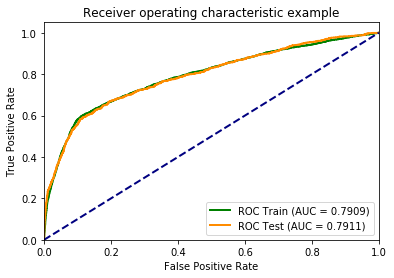

In [58]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
get_performance_metrics(y_train=y_train, 
                        y_train_pred=model.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=model.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=model.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=model.predict_proba(test_standardized_data)[:,1])

In [59]:
# The prediction for those who subscribed to the term deposit (y = 1) is poor.
# Consider to use over-sampling method or other improvements to see whether they can help.
print(classification_report(y_true=y_test, 
                            y_pred=model.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7325
           1       0.72      0.22      0.34       913

   micro avg       0.90      0.90      0.90      8238
   macro avg       0.82      0.60      0.64      8238
weighted avg       0.89      0.90      0.88      8238



In [60]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                             y_pred=model.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,7248,77
True 1,713,200


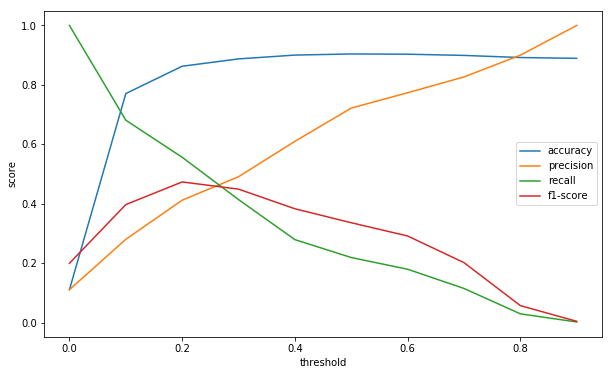

In [61]:
# Given different thresholds (probability), what is the corresponding metric for 
# 'subscribed' customers?
threshold_metric_visualization(y_test=y_test,
                               prediction=model.predict_proba(test_standardized_data)[:,1])

# 9. Summary 
- The purpose of this notebook is to build a baseline model and to discover problems that might need some improvements later. Each dataset is unique and has its specific objectives that aimed to achieve. Therefore, the problems and the corresponding improvements might be different across datasets.
- **Problems I have discovered:**
    - Outlier imputation: I have explored outliers by looking at the box-plot visualizations. However, I didn't perform any outlier imputation. For Logistic Regression sigmoid function, it has a higher tolerance on outliers compared with the traditional linear regression.
    - Unbalanced labels: From the model performance report, it's obvious that the unbalanced labels resulted in a poor prediction, especially for label = 1 (subscribed customers).
- **Solutions / Improvements (all treatments are covered in the next notebook!)**
    - Unbalanced labels
        - 1. Use SMOTE to perform over-sampling and thus I could attain a dataset with balanced labels.
        - 2. Assign different penalties to two labels with the higher penalty assigned to label = 1. (The main point is to discover the 'subscribed' customers, and thus I will force the model to learn more on the pattern of subscribed customers.)